# Get Vons locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
from random import randint
from time import sleep

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Vons only has stores in California and Nevada. Let's get ZIP Codes for those states

In [4]:
zips = (
    pd.read_csv("../_reference/data/zips_reference.csv")
    .sort_values("pop2012", ascending=False)
    .query('state =="CA" or state=="NV"')
).reset_index(drop=True)

#### Make a list of most-populous 1,000 ZIP Codes for store locator requests

In [5]:
zip_list = list(zips["zip"].head(1000).sort_values(ascending=False).unique())

---

#### Set up requests

In [6]:
cookies = {
    "visid_incap_1610354": "WEs7V0NUQIWIoZuvZikP3XjHmWUAAAAAQUIPAAAAAADwxu7De58xQlB7v1/vTCcK",
    "at_check": "true",
    "_gcl_au": "1.1.231430127.1704576908",
    "AMCVS_A7BF3BC75245ADF20A490D4D%40AdobeOrg": "1",
    "ECommBanner": "vons",
    "ECommSignInCount": "0",
    "SAFEWAY_MODAL_LINK": "",
    "absVisitorId": "1df4561d-d10f-4ff3-82a2-2c3893b9ede6",
    "__pdst": "16454546fda94ca4804e26866b77c281",
    "OptanonAlertBoxClosed": "2024-01-06T22:03:40.586Z",
    "abs_gsession": "%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22Selection%22%3A%22user%22%2C%22preference%22%3A%22J4U%22%2C%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%2C%22SHOP%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%7D%7D",
    "abs_previouslogin": "%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22Selection%22%3A%22user%22%2C%22preference%22%3A%22J4U%22%2C%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%2C%22SHOP%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%7D%7D",
    "incap_ses_552_1610354": "+iWCdt3SWi1N0vheLxqpBytitGUAAAAANaF4HAMb05GCepj6EOJ5sQ==",
    "AMCV_A7BF3BC75245ADF20A490D4D%40AdobeOrg": "179643557%7CMCIDTS%7C19750%7CMCMID%7C57339740982539071332932117204591180451%7CMCAAMLH-1706925231%7C9%7CMCAAMB-1706925231%7C6G1ynYcLPuiQxYZrsz_pkqfLG9yMXBpb2zX5dvJdYQJzPXImdj0y%7CMCOPTOUT-1706327631s%7CNONE%7CvVersion%7C5.5.0",
    "SWY_SYND_USER_INFO": "%7B%22storeAddress%22%3A%22%22%2C%22storeZip%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%2C%22preference%22%3A%22J4U%22%7D",
    "SWY_SHARED_SESSION_INFO": "%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22preference%22%3A%22J4U%22%2C%22Selection%22%3A%22user%22%2C%22wfcStoreId%22%3A%225799%22%2C%22userData%22%3A%7B%7D%2C%22grsSessionId%22%3A%2244895298-1e6b-4139-bb0e-0f76e26547a1%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22storeId%22%3A%222053%22%2C%22zipcode%22%3A%2292110%22%2C%22userData%22%3A%7B%7D%7D%2C%22SHOP%22%3A%7B%22storeId%22%3A%222053%22%2C%22zipcode%22%3A%2292110%22%2C%22userData%22%3A%7B%7D%7D%7D%7D",
    "reese84": "3:HsHKEYYR/T/Sm2dUQHh9HA==:Z4aV841G3Lo8SlCNYM3hWgeH57JqhHfX8QWhstFvI957bgr9hwe/lU9vNNnznEtG59NKl2u7ymPHg2zPwq47KANgdTJV+8xVIYloDSGvPbiPINQU9LWoA9cvc5eW6P0o10ib6bTiQss6UrdgHu0n0HKScce0vBf7Q8cWrDouZIpgm6ZoVDzhbNC0CHeNrB0PSJXyNFVNlx3ChAYx0eWk0JJ60ysO3+A3wpxr5dHa0bI1ggyk6hyATLwWNiBTZJvuUOXxUIVQQ+zJGOGQcNISiIZ926b4IyPVSuHeG5JC6MFFkvAdud2r7MnOmq5iOfA9v7ET1DMSaT6jPqkttRrKF2Botd86CWjEL6aZ4zP7dbsd0DcJ4Pq52JUa8v04HItTeaxxKStm/4U9DBFiLFkoRhR9hev7itR/VQ587mvaNIIGBTK2T5C4xSE8zPRnBasIjcd7TMCS65TgzefpO7NdAQ==:4HgXP3+fVcr248ma5U33CBLp/gH0TDIn/vIJyZkdKUA=",
    "nlbi_1610354": "pbViNeZo9U0/YwCYwfGJNgAAAADe6U6vKvJodWQH9vypo/66",
    "_fbp": "fb.1.1706322162873.1332478369",
    "__gads": "ID=499c1559ae081507:T=1706322163:RT=1706322163:S=ALNI_MboZjz5K5JlJS1An1EWLUpIadzeZQ",
    "__gpi": "UID=00000d8885f4bd3e:T=1706322163:RT=1706322163:S=ALNI_MY5GXHDBkqMbnnUNH9Zf8fPbUOBQg",
    "_ga_9E95BVP6JP": "GS1.2.1706321980.4.1.1706322239.0.0.0",
    "s_ivc": "true",
    "ECommRedirectURL": "https%3A%2F%2Flocal.vons.com%2Fca%2Flos-angeles.html%3Faction%3DchangeStore",
    "mbox": "PC#07ecdddf789544108ba06fae673a100f.35_0#1769567053|session#5e310102968f460caf96419681054f08#1706324113",
    "OptanonConsent": "isGpcEnabled=0&datestamp=Fri+Jan+26+2024+18%3A24%3A13+GMT-0800+(Pacific+Standard+Time)&version=202306.2.0&browserGpcFlag=0&isIABGlobal=false&hosts=&consentId=8d872f82-e46f-4826-8643-082f1d173480&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0004%3A1%2CC0003%3A1&geolocation=US%3BCA&AwaitingReconsent=false",
    "_ga_9ECKX3GB5E": "GS1.1.1706322253.1.0.1706322253.0.0.0",
    "nlbi_1610354_2147483392": "X3eNOB4UWUsvVSyawfGJNgAAAADAOV2aVLr8jl8TtufwzESh",
    "s_sq": "sfsafewayprod1%3D%2526c.%2526a.%2526activitymap.%2526page%253Dvons%25253Aloyalty%25253Ahome%2526link%253DUse%252520my%252520current%252520location%2526region%253DstoreFulfillmentModal%2526pageIDType%253D1%2526.activitymap%2526.a%2526.c%2526pid%253Dvons%25253Aloyalty%25253Ahome%2526pidt%253D1%2526oid%253DUse%252520my%252520current%252520location%2526oidt%253D3%2526ot%253DSUBMIT",
}

headers = {
    "authority": "www.vons.com",
    "accept": "application/json, text/plain, */*",
    "accept-language": "en-US,en;q=0.9,es;q=0.8",
    # 'cookie': 'visid_incap_1610354=WEs7V0NUQIWIoZuvZikP3XjHmWUAAAAAQUIPAAAAAADwxu7De58xQlB7v1/vTCcK; at_check=true; _gcl_au=1.1.231430127.1704576908; AMCVS_A7BF3BC75245ADF20A490D4D%40AdobeOrg=1; ECommBanner=vons; ECommSignInCount=0; SAFEWAY_MODAL_LINK=; absVisitorId=1df4561d-d10f-4ff3-82a2-2c3893b9ede6; __pdst=16454546fda94ca4804e26866b77c281; OptanonAlertBoxClosed=2024-01-06T22:03:40.586Z; abs_gsession=%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22Selection%22%3A%22user%22%2C%22preference%22%3A%22J4U%22%2C%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%2C%22SHOP%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%7D%7D; abs_previouslogin=%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22Selection%22%3A%22user%22%2C%22preference%22%3A%22J4U%22%2C%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%2C%22SHOP%22%3A%7B%22zipcode%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%7D%7D%7D; incap_ses_552_1610354=+iWCdt3SWi1N0vheLxqpBytitGUAAAAANaF4HAMb05GCepj6EOJ5sQ==; AMCV_A7BF3BC75245ADF20A490D4D%40AdobeOrg=179643557%7CMCIDTS%7C19750%7CMCMID%7C57339740982539071332932117204591180451%7CMCAAMLH-1706925231%7C9%7CMCAAMB-1706925231%7C6G1ynYcLPuiQxYZrsz_pkqfLG9yMXBpb2zX5dvJdYQJzPXImdj0y%7CMCOPTOUT-1706327631s%7CNONE%7CvVersion%7C5.5.0; SWY_SYND_USER_INFO=%7B%22storeAddress%22%3A%22%22%2C%22storeZip%22%3A%2292110%22%2C%22storeId%22%3A%222053%22%2C%22preference%22%3A%22J4U%22%7D; SWY_SHARED_SESSION_INFO=%7B%22info%22%3A%7B%22COMMON%22%3A%7B%22userType%22%3A%22G%22%2C%22zipcode%22%3A%2292110%22%2C%22banner%22%3A%22vons%22%2C%22preference%22%3A%22J4U%22%2C%22Selection%22%3A%22user%22%2C%22wfcStoreId%22%3A%225799%22%2C%22userData%22%3A%7B%7D%2C%22grsSessionId%22%3A%2244895298-1e6b-4139-bb0e-0f76e26547a1%22%2C%22siteType%22%3A%22C%22%2C%22customerType%22%3A%22%22%7D%2C%22J4U%22%3A%7B%22storeId%22%3A%222053%22%2C%22zipcode%22%3A%2292110%22%2C%22userData%22%3A%7B%7D%7D%2C%22SHOP%22%3A%7B%22storeId%22%3A%222053%22%2C%22zipcode%22%3A%2292110%22%2C%22userData%22%3A%7B%7D%7D%7D%7D; reese84=3:HsHKEYYR/T/Sm2dUQHh9HA==:Z4aV841G3Lo8SlCNYM3hWgeH57JqhHfX8QWhstFvI957bgr9hwe/lU9vNNnznEtG59NKl2u7ymPHg2zPwq47KANgdTJV+8xVIYloDSGvPbiPINQU9LWoA9cvc5eW6P0o10ib6bTiQss6UrdgHu0n0HKScce0vBf7Q8cWrDouZIpgm6ZoVDzhbNC0CHeNrB0PSJXyNFVNlx3ChAYx0eWk0JJ60ysO3+A3wpxr5dHa0bI1ggyk6hyATLwWNiBTZJvuUOXxUIVQQ+zJGOGQcNISiIZ926b4IyPVSuHeG5JC6MFFkvAdud2r7MnOmq5iOfA9v7ET1DMSaT6jPqkttRrKF2Botd86CWjEL6aZ4zP7dbsd0DcJ4Pq52JUa8v04HItTeaxxKStm/4U9DBFiLFkoRhR9hev7itR/VQ587mvaNIIGBTK2T5C4xSE8zPRnBasIjcd7TMCS65TgzefpO7NdAQ==:4HgXP3+fVcr248ma5U33CBLp/gH0TDIn/vIJyZkdKUA=; nlbi_1610354=pbViNeZo9U0/YwCYwfGJNgAAAADe6U6vKvJodWQH9vypo/66; _fbp=fb.1.1706322162873.1332478369; __gads=ID=499c1559ae081507:T=1706322163:RT=1706322163:S=ALNI_MboZjz5K5JlJS1An1EWLUpIadzeZQ; __gpi=UID=00000d8885f4bd3e:T=1706322163:RT=1706322163:S=ALNI_MY5GXHDBkqMbnnUNH9Zf8fPbUOBQg; _ga_9E95BVP6JP=GS1.2.1706321980.4.1.1706322239.0.0.0; s_ivc=true; ECommRedirectURL=https%3A%2F%2Flocal.vons.com%2Fca%2Flos-angeles.html%3Faction%3DchangeStore; mbox=PC#07ecdddf789544108ba06fae673a100f.35_0#1769567053|session#5e310102968f460caf96419681054f08#1706324113; OptanonConsent=isGpcEnabled=0&datestamp=Fri+Jan+26+2024+18%3A24%3A13+GMT-0800+(Pacific+Standard+Time)&version=202306.2.0&browserGpcFlag=0&isIABGlobal=false&hosts=&consentId=8d872f82-e46f-4826-8643-082f1d173480&interactionCount=1&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0004%3A1%2CC0003%3A1&geolocation=US%3BCA&AwaitingReconsent=false; _ga_9ECKX3GB5E=GS1.1.1706322253.1.0.1706322253.0.0.0; nlbi_1610354_2147483392=X3eNOB4UWUsvVSyawfGJNgAAAADAOV2aVLr8jl8TtufwzESh; s_sq=sfsafewayprod1%3D%2526c.%2526a.%2526activitymap.%2526page%253Dvons%25253Aloyalty%25253Ahome%2526link%253DUse%252520my%252520current%252520location%2526region%253DstoreFulfillmentModal%2526pageIDType%253D1%2526.activitymap%2526.a%2526.c%2526pid%253Dvons%25253Aloyalty%25253Ahome%2526pidt%253D1%2526oid%253DUse%252520my%252520current%252520location%2526oidt%253D3%2526ot%253DSUBMIT',
    "ocp-apim-subscription-key": "7bad9afbb87043b28519c4443106db06",
    "referer": "https://www.vons.com/?goto=https%3A%2F%2Flocal.vons.com%2Fca%2Flos-angeles.html",
    "sec-ch-ua": '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
}

#### Loop through the list to set a search radius in each ZIP

In [7]:
stores_list = []

for z in tqdm(zip_list):

    params = {
        "zipcode": z,
        "size": "20",
        "radius": "20",
        "excludeBanners": "none",
    }

    response = requests.get(
        "https://www.vons.com/abs/pub/xapi/storeresolver/v2/all",
        params=params,
        cookies=cookies,
        headers=headers,
    )

    src = pd.DataFrame(response.json()["instore"])
    stores_list.append(src)
    # sleep(randint(2, 5))

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Create a dataframe by flattening nested stores key

In [8]:
src = (
    pd.json_normalize(pd.concat(stores_list)["stores"].reset_index(drop=True))[
        [
            "locationId",
            "timezone",
            "domainName",
            "localPage",
            "address.line1",
            "address.city",
            "address.state",
            "address.zipcode",
        ]
    ]
    .drop_duplicates(subset="localPage")
    .rename(
        columns={
            "locationId": "id",
            "timezone": "timezone",
            "domainName": "name",
            "localPage": "url",
            "address.line1": "address",
            "address.city": "city",
            "address.state": "state",
            "address.zipcode": "zip",
        }
    )
)

#### Just Vons

In [9]:
vons_df = src.query("name == 'Vons'")

---

## Geography

#### Get longitude and latitude on each location page by first creating a store url list

In [10]:
vons_urls = list(vons_df["url"].unique())

#### Loop through each URL and inline meta tags for lon/lat 

In [11]:
geo_list = []

for u in tqdm(vons_urls):
    response = requests.get(u)
    soup = BeautifulSoup(response.text, "html.parser")
    geo_dict = {
        "latitude": soup.select('meta[itemprop="latitude"]')[0]["content"],
        "longitude": soup.select('meta[itemprop="longitude"]')[0]["content"],
        "url": u,
    }
    geo_list.append(geo_dict)

  0%|          | 0/187 [00:00<?, ?it/s]

#### Read list of story dictionaries into dataframe

In [12]:
geo_df = pd.DataFrame(geo_list)

#### Merge lon/lack back into main dataframe

In [13]:
df = pd.merge(vons_df, geo_df, on="url").reset_index()

In [14]:
len(df)

187

---

#### Make a geodataframe from lon/lat

In [15]:
gdf = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.longitude, geo_df.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

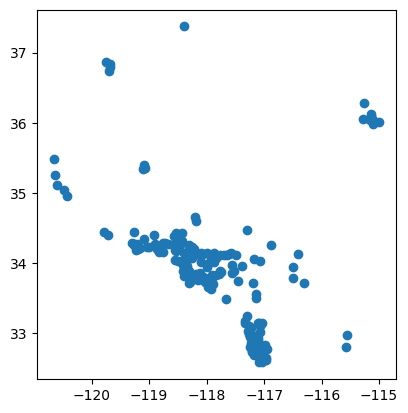

In [16]:
gdf.plot()

---

## Exports

#### CSV

In [17]:
df.to_csv("data/processed/vons_locations.csv", index=False)

#### JSON

In [18]:
df.to_json("data/processed/vons_locations.json", indent=4, orient="records")

#### GeoJSON

In [19]:
gdf.to_file("data/processed/vons_locations.geojson", driver="GeoJSON")